In [131]:
### IMPORTS ###
import os, glob, re, time
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import sklearn

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import Binarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

## Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier # KNN c
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
import lightgbm as lgb

## Evaluation
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [230]:
### GLOBAL VARIABLES ###
RAND_STATE = 0
N_FOLDS = 5

### FUNCTIONS ###
def getPredictions(X):
    """ Converts probabilities in df to labels
    Args:
        X (dataframe): Columns correponds to probabilities of different models
    Returns:
        dataframe: Predicted labels (0 or 1)
    """
    predictions = np.zeros(X.shape)
    predictions[X > 0.5] = 1
    return pd.DataFrame(predictions, columns=list(X))
  
def getNCombinations(params_grid):
    '''Calculates number of all possible combinations'''
    list_lengths = [len(x) for x in params_grid.values()]
    return np.prod(list_lengths)
  
def runRandSearchCV(model, params_grid, params_search,
                    X_alltrain, y_alltrain, filename):
    '''Run randomized cross-validation grid search and pickle best parameters'''
    
    print("Number of all possible combinations:",
          getNCombinations(params_grid))

    # Random search of parameters across n_iter different
    # combinations using all available cores
    grid_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=params_grid,
        n_jobs=-1,
        **params_search
    )
    grid_search.fit(X_alltrain, y_alltrain)
    
    print("Best parameters")
    print(grid_search.best_params_)
    pkl_obj = [grid_search.best_params_, grid_search.cv_results_]
    
    params_wpath = os.path.join("dump/params/", filename)
    print("Saved parameters to:", params_wpath)
    with open(params_wpath, "wb") as f:
        pkl.dump(pkl_obj, f)

def runL1ModelCV(model, X_alltrain, y_alltrain, X_test=None, filename=None,
                 best_threshold=False, n_folds=N_FOLDS, random_state=RAND_STATE,
                 algorithm="others", **kwargs):
    '''Performs cross-validation on L1 model to 1) calculate early stopping number
    2) determine optimal prediction threshold 3) return CV metrics 4) predict test set
    
    Does not perform early_stopping_rounds when trained with entire training dataset!
    '''
    
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True,
                          random_state=random_state)
    
    list_thresholds = []
    list_accs = []
    max_ntrees = 0 # Initialise max number of trees 
    for i, (train_idx, vld_idx) in enumerate(skf.split(X_alltrain, y_alltrain)):
        print("#"*10)
        print("Fold", i)
        print("#"*10)
        X_train = X_alltrain.iloc[train_idx,:]
        y_train = y_alltrain.iloc[train_idx]
        X_vld = X_alltrain.iloc[vld_idx,:]
        y_vld = y_alltrain.iloc[vld_idx]
        
        # MODEL FIT
        if algorithm == "others":
            model.fit(X_train, y_train)
        elif algorithm == "xgb":
            # XGBoost (cannot handle categorical features)
            model.fit(X_train, y_train, eval_set=[(X_vld, y_vld)],
                      early_stopping_rounds=10, **kwargs)            
            # model.best_ntree_limit: best no. of trees
            if model.best_ntree_limit > max_ntrees:
                max_ntrees = model.best_ntree_limit
        
        elif algorithm == "lgbm":
            # LightGBM
            model.fit(X_train, y_train, eval_set=[(X_vld, y_vld)],
                      early_stopping_rounds=10, **kwargs)
            # model.best_iteration_ starts from iteration 1
            if model.best_iteration_ > max_ntrees:
                max_ntrees = model.best_iteration_
        
        elif algorithm == "catboost":
            # CatBoost
            model.fit(X_train, y_train, eval_set=[(X_vld, y_vld)],
                      early_stopping_rounds=10, **kwargs)
            # model.best_iteration_ starts from iteration 1
            if model.best_iteration_ > max_ntrees:
                max_ntrees = model.best_iteration_ + 1
        
        else:
            raise ValueError("argument not in list of choices")
        
        # MODEL PREDICT
        p_train = model.predict_proba(X_train)[:,1]
        ypred_train = (p_train > 0.5).astype(int)

        p_vld = model.predict_proba(X_vld)[:,1]
        ypred_vld = (p_vld > 0.5).astype(int)
        
        print("Train set:")
        print(confusion_matrix(y_train, ypred_train))
        print("Accuracy = {:.3f}, F1 = {:.3f}".format(
            accuracy_score(y_train, ypred_train)*100,
            f1_score(y_train, ypred_train)*100))

        print("Validation set:")
        print(confusion_matrix(y_vld, ypred_vld))
        print("Accuracy = {:.3f}, F1 = {:.3f}".format(
            accuracy_score(y_vld, ypred_vld)*100,
            f1_score(y_vld, ypred_vld)*100))
        
        # Search for best threshold
        threshold, acc = searchThreshold(p_vld, y_vld)
        list_thresholds.append(threshold)
        list_accs.append(acc)
    
    container = [list_thresholds, list_accs]
    
    if X_test is not None:
        # Prediction of test set with model fitted on entire training set
        if algorithm != "others":
            # Change parameter if model is a gbm
            n_trees = math.ceil(max_ntrees/100) * 100 # round up to nearest 100
            print("Final model: {} trees\n".format(n_trees))
            model.n_estimators = n_trees
            container.append(n_trees) # return extra value
        
        # MODEL FIT: TEST
        if algorithm in {"lgbm", "catboost"}:
            # kwargs: cat_features, verbose (no early_stopping_rounds!)
            model.fit(X_alltrain, y_alltrain, **kwargs)
        else:
            model.fit(X_alltrain, y_alltrain)
        
        # MODEL PREDICT: TEST
        if best_threshold == False:
            ypred_test = model.predict(X_test)
        else:
            p_test = model.predict_proba(X_test)[:,1]
            # Prediction based on best threshold
            binary_encoder = Binarizer(threshold=np.mean(list_thresholds))
            ypred_threshold = binary_encoder.fit_transform(pd.DataFrame(p_test))
            print("Final threshold = {:.5f}".format(np.mean(list_thresholds)))
            ypred_test = ypred_threshold.astype('int').ravel() # .ravel returns a view
        
        # SAVE FILE
        if filename is not None:
            print(ypred_test)
            saveResult(ypred_test, filename)
    
    return container
    
def searchThreshold(p, y):
    # Search for threshold that maximises accuracy
    # No assumption of convexity in (f: threshold -> acc)
    
    p = pd.Series(p) # Explicit type conversion to pd.Series
    
    max_accuracy = 0
    max_threshold = 0
    for cut in p.sort_values():
        binary_encoder = Binarizer(threshold=cut)
        ypred_threshold = binary_encoder.fit_transform(pd.DataFrame(p))
        acc = accuracy_score(y, ypred_threshold)
        if max_accuracy < acc:
            max_accuracy = acc
            max_threshold = cut
    
    print("Best threshold: {:.4f} (Accuracy = {:.2f})".format(
        max_threshold, max_accuracy*100))
    
    return max_threshold, max_accuracy

def plotROC(p, y):    
    fpr, tpr, threshold = roc_curve(y, p, drop_intermediate=True)
    AUC = auc(fpr, tpr)
    
    max_threshold, max_accuracy = searchThreshold(p, y)
    
    # Plot ROC curve
    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    lab = "ROC (AUC: {:.3f})".format(AUC)
    ax.plot(fpr, tpr, label=lab)
    ax.scatter(fpr[threshold == max_threshold],
               tpr[threshold == max_threshold])
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()

    return fig

def saveResult(ypred_test, filename):
    '''Saves predicted labels to csv file'''
    # Size of test set is 24421
    assert ypred_test.size == 24421
    results_dict = {
        "id": np.arange(1, ypred_test.size + 1),
        "prediction": ypred_test
    }
    results = pd.DataFrame(results_dict)
    
    path = os.path.join("dump/submissions/", filename)
    print("Saved submission file to:", path)
    results.to_csv(path, index=False)   

def saveL1Test(model, X_alltrain, y_alltrain, X_test, filename):
    model.fit(X_alltrain, y_alltrain)
    ypred_test = model.predict(X_test)
    saveResult(ypred_test, filename)

In [212]:
binary_encoder = Binarizer(threshold=0.5)
ypred_test = binary_encoder.fit_transform(pd.DataFrame(np.arange(1000)))
print(ypred_test.ravel().shape)

(1000,)


In [21]:
## Import y_alltrain
TRAIN_RPATH = "dump/data/nopp_alltrain.pkl"
with open(TRAIN_RPATH, "rb") as f:
    _, y_alltrain = pkl.load(f)

In [22]:
## Import L1 features
L1_WPATH1 = "dump/data/L1_wxpp1_pca.pkl"
with open(L1_WPATH1, "rb") as f:
    pca_alltrain, pca_test = pkl.load(f)
print(pca_alltrain.shape)
print(pca_test.shape)

(24421, 4)
(24421, 4)


### Import model probabilities

In [23]:
RDIR = "dump/proba/stack1/*"
list_files = glob.glob(RDIR)
list_files.sort()

model_names = [re.search(".*/(.*).pkl", rpath).group(1)
               for rpath in list_files]
print(model_names)
allp_alltrain = pd.DataFrame(columns=model_names)
allp_test = pd.DataFrame(columns=model_names)

# Concatenate all probabilities to form dataframe
for rpath, name in zip(list_files, model_names):
    with open(rpath, "rb") as f:
        p_alltrain, p_test = pkl.load(f)
    allp_alltrain[name] = p_alltrain
    allp_test[name] = p_test
    
print(allp_alltrain.shape)
print(allp_test.shape)

['nopp_et1', 'nopp_et2', 'nopp_lgbm1', 'nopp_lgbm2', 'nopp_rf1', 'nopp_rf2', 'nopp_xgb1', 'nopp_xgb2', 'wxpp_knn1']
(24421, 9)
(24421, 9)


### Concatenate features and model outputs

In [8]:
## Concatenate model outputs and L1 features
X_alltrain = np.hstack([allp_alltrain, pca_alltrain])
print(X_alltrain.shape)
X_test = np.hstack([allp_test, pca_test])
print(X_test.shape)

(24421, 13)
(24421, 13)


In [225]:
## Split into training and validation set
X_train, X_vld, y_train, y_vld = train_test_split(allp_alltrain, y_alltrain,
                                                  test_size=0.2, random_state=RAND_STATE)
print(X_train.shape)
print(y_train.shape)
print(X_vld.shape)
print(y_vld.shape)

(19536, 9)
(19536,)
(4885, 9)
(4885,)


### Evaluation: Individual models

In [13]:
allypred_alltrain = getPredictions(allp_alltrain)

print("Training set:")
for colname, ypred_alltrain in allypred_alltrain.iteritems():
    print(colname)
    print("Accuracy = {:.5f}, F1 = {:.5f}".format(
        accuracy_score(y_alltrain, ypred_alltrain),
        f1_score(y_alltrain, ypred_alltrain)))

Training set:
nopp_et1
Accuracy = 0.84816, F1 = 0.64476
nopp_et2
Accuracy = 0.80509, F1 = 0.67500
nopp_lgbm1
Accuracy = 0.87326, F1 = 0.71587
nopp_lgbm2
Accuracy = 0.83981, F1 = 0.72021
nopp_rf1
Accuracy = 0.86282, F1 = 0.68258
nopp_rf2
Accuracy = 0.83481, F1 = 0.70700
nopp_xgb1
Accuracy = 0.87326, F1 = 0.71477
nopp_xgb2
Accuracy = 0.84358, F1 = 0.72367
wxpp_knn1
Accuracy = 0.84870, F1 = 0.66222


### Evaluation: Correlation between model predictions

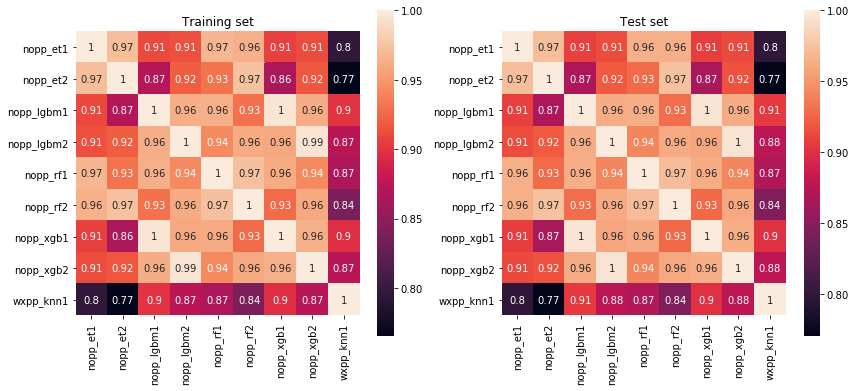

In [14]:
corr_alltrain = allp_alltrain.corr(method='pearson')
corr_test = allp_test.corr(method='pearson')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
sns.heatmap(corr_alltrain, square=True, annot=True, ax=ax1)
sns.heatmap(corr_test, square=True, annot=True, ax=ax2)
ax1.set_title("Training set")
ax2.set_title("Test set")
plt.show()

### Evaluation: Wrongly classified samples

In [25]:
allypred_alltrain = getPredictions(allp_alltrain)

#### Samples classified incorrectly by all models

In [38]:
## Not a single one of the model gets it correct
# ypred_prod = allypred_alltrain.apply(np.prod, axis=1)
# ypred_sum = allypred_alltrain.apply(np.sum, axis=1)

##
allwrong_0 = allypred_alltrain.loc[(ypred_prod == 1) & (y_alltrain == 0),:]
allwrong_1 = allypred_alltrain.loc[(ypred_sum == 0) & (y_alltrain == 1),:]
print(allwrong_0.shape[0])
print(allwrong_0.shape[1])

       nopp_et1  nopp_et2  nopp_lgbm1  nopp_lgbm2  nopp_rf1  nopp_rf2  \
3           1.0       1.0         1.0         1.0       1.0       1.0   
37          1.0       1.0         1.0         1.0       1.0       1.0   
69          1.0       1.0         1.0         1.0       1.0       1.0   
71          1.0       1.0         1.0         1.0       1.0       1.0   
119         1.0       1.0         1.0         1.0       1.0       1.0   
...         ...       ...         ...         ...       ...       ...   
24306       1.0       1.0         1.0         1.0       1.0       1.0   
24358       1.0       1.0         1.0         1.0       1.0       1.0   
24360       1.0       1.0         1.0         1.0       1.0       1.0   
24402       1.0       1.0         1.0         1.0       1.0       1.0   
24411       1.0       1.0         1.0         1.0       1.0       1.0   

       nopp_xgb1  nopp_xgb2  wxpp_knn1  
3            1.0        1.0        1.0  
37           1.0        1.0        1.0  


### Stacking: Hard voting

In [39]:
allypred_alltrain = getPredictions(allp_alltrain)

# Average the predicted labels
voteL1_p_alltrain = allypred_alltrain.mean(axis=1)
voteL1_ypred_alltrain = (voteL1_p_alltrain > 0.5).astype(int)

print("Train set:")
print(classification_report(y_alltrain, voteL1_ypred_alltrain))
print(confusion_matrix(y_alltrain, voteL1_ypred_alltrain))
print("Accuracy = {:.5f}, F1 = {:.5f}".format(
    accuracy_score(y_alltrain, voteL1_ypred_alltrain),
    f1_score(y_alltrain, voteL1_ypred_alltrain)))

Train set:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91     18560
           1       0.73      0.73      0.73      5861

    accuracy                           0.87     24421
   macro avg       0.82      0.82      0.82     24421
weighted avg       0.87      0.87      0.87     24421

[[16930  1630]
 [ 1556  4305]]
Accuracy = 0.86954, F1 = 0.72991


In [98]:
# Test set predictions
allypred_test = getPredictions(allp_test)

voteL1_p_test = allypred_test.mean(axis=1)
voteL1_ypred_test = (voteL1_p_test > 0.5).astype(int)
saveResult(voteL1_ypred_test, "stack1_vote.csv")

   nopp_et2  nopp_lgbm1  nopp_lgbm2  nopp_rf1
1  0.244020    0.010171    0.014171  0.088398
2  0.180621    0.013157    0.039981  0.029455
3  0.333171    0.176918    0.445093  0.208681
4  0.017519    0.002298    0.007532  0.004912
   nopp_et2  nopp_lgbm1  nopp_lgbm2  nopp_rf1
1       0.0         0.0         0.0       0.0
2       0.0         0.0         0.0       0.0
3       0.0         0.0         0.0       0.0
4       0.0         0.0         0.0       0.0 

Saved submission file to: dump/submissions/stack1_vote.csv


### Stacking: Soft averaging

In [41]:
avgL1_p_alltrain = allp_alltrain.mean(axis=1)
avgL1_ypred_alltrain = (avgL1_p_alltrain > 0.5).astype(int)

print("Train set:")
print(classification_report(y_alltrain, avgL1_ypred_alltrain))
print(confusion_matrix(y_alltrain, avgL1_ypred_alltrain))
print("Accuracy = {:.5f}, F1 = {:.5f}".format(
    accuracy_score(y_alltrain, avgL1_ypred_alltrain),
    f1_score(y_alltrain, avgL1_ypred_alltrain)))

Train set:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91     18560
           1       0.72      0.75      0.73      5861

    accuracy                           0.87     24421
   macro avg       0.82      0.83      0.82     24421
weighted avg       0.87      0.87      0.87     24421

[[16803  1757]
 [ 1444  4417]]
Accuracy = 0.86892, F1 = 0.73403


In [128]:
print(searchThreshold(avgL1_p_alltrain, y_alltrain))

Best threshold: 0.57854 (Acc = 87.425) accuracy
(0.5785430353666662, 0.8742475738094263)


In [100]:
# Test set predictions
avgL1_p_test = allp_test.mean(axis=1)
avgL1_ypred_test = (avgL1_p_test > 0.5).astype(int)
saveResult(avgL1_ypred_test, "stack1_avg.csv")

Saved submission file to: dump/submissions/stack1_avg.csv


### Stacking: Logistic Regression

In [19]:
## MODEL 1
params_logreg = {
    "C": 1.0,
    "class_weight": None,
    "solver": "lbfgs"
}
logreg = LogisticRegression(**params_logreg)

runL1Model(logreg, allp_alltrain, y_alltrain)
# saveL1Test(logreg, allp_alltrain, y_alltrain,
#            allp_test, "stack1_logreg1.csv")

Training set
Accuracy = 87.257% +/- 0.075
F1 = 72.346% +/- 0.179
Test set
Accuracy = 87.261% +/- 0.133
F1 = 72.345% +/- 0.483


In [138]:
## MODEL 2 (Class imbalance)
params_logreg = {
    'C': 1.0,
    'class_weight': 'balanced',
    'solver': 'lbfgs'
}
logreg = LogisticRegression(**params_logreg)
runL1Model(logreg, allp_alltrain, y_alltrain)
# saveL1Test(logreg, allp_alltrain, y_alltrain,
#            allp_test, "stack1_logreg2.csv")

Train set:
[[12438  2410]
 [  654  4034]]
Accuracy = 84.31613, F1 = 72.47575
Validation set:
[[3101  611]
 [ 181  992]]
Accuracy = 83.787, F1 = 71.470

Saved submission file to: dump/submissions/stack1_logreg2.csv


### Stacked: MLP

In [21]:
params_mlp = {
    'hidden_layer_sizes': (12,15,18,18,18,12,12),
    'max_iter': 1000,
    'alpha': 1e-4,
    'solver': 'adam',
    'verbose': 10,
    'random_state': RAND_STATE,
    'learning_rate_init': 0.01
}
mlp = MLPClassifier(**params_mlp)

runL1Model(mlp, allp_alltrain, y_alltrain)
# saveL1Test(mlp, allp_alltrain, y_alltrain,
#            allp_test, "stack1_mlp1.csv")

Iteration 1, loss = 0.34221952
Iteration 2, loss = 0.28674691
Iteration 3, loss = 0.28630566
Iteration 4, loss = 0.28508388
Iteration 5, loss = 0.28233765
Iteration 6, loss = 0.28287764
Iteration 7, loss = 0.28012168
Iteration 8, loss = 0.28008007
Iteration 9, loss = 0.28107635
Iteration 10, loss = 0.28154961
Iteration 11, loss = 0.28265340
Iteration 12, loss = 0.28048653
Iteration 13, loss = 0.27863221
Iteration 14, loss = 0.27779995
Iteration 15, loss = 0.27895038
Iteration 16, loss = 0.28190821
Iteration 17, loss = 0.27994723
Iteration 18, loss = 0.28033617
Iteration 19, loss = 0.27749388
Iteration 20, loss = 0.27928953
Iteration 21, loss = 0.28047876
Iteration 22, loss = 0.27717067
Iteration 23, loss = 0.27680499
Iteration 24, loss = 0.27933479
Iteration 25, loss = 0.27975380
Iteration 26, loss = 0.27795119
Iteration 27, loss = 0.27619633
Iteration 28, loss = 0.27679712
Iteration 29, loss = 0.27642537
Iteration 30, loss = 0.27881953
Iteration 31, loss = 0.27634515
Iteration 32, los

### Stacked: Random Forest

In [229]:
params_model = {
    'n_estimators': 3000,
    'min_samples_split': 5,
    'min_samples_leaf': 5,
    'max_depth': 10,
    'max_leaf_nodes': 30,
    'bootstrap': True,
    'max_samples': 0.8,
    'n_jobs': -1,
    'random_state': RAND_STATE
    # 'class_weight': 'balanced_subsample'
}
rf = RandomForestClassifier(**params_model)

runL1ModelCV(rf, allp_alltrain, y_alltrain, allp_test,
             "stack1_rf_threshold.csv",
             best_threshold=True)

##########
Fold 0
##########
Train set:
[[14018   830]
 [ 1539  3149]]
Accuracy = 87.874, F1 = 72.666
Validation set:
[[3531  181]
 [ 423  750]]
Accuracy = 87.636, F1 = 71.293
Best threshold: 0.4303 (Accuracy = 88.11)
##########
Fold 1
##########
Train set:
[[14014   834]
 [ 1487  3202]]
Accuracy = 88.120, F1 = 73.398
Validation set:
[[3466  246]
 [ 386  786]]
Accuracy = 87.060, F1 = 71.325
Best threshold: 0.5067 (Accuracy = 87.12)
##########
Fold 2
##########
Train set:
[[14002   846]
 [ 1477  3212]]
Accuracy = 88.110, F1 = 73.442
Validation set:
[[3487  225]
 [ 415  757]]
Accuracy = 86.896, F1 = 70.288
Best threshold: 0.5453 (Accuracy = 87.16)
##########
Fold 3
##########
Train set:
[[13980   868]
 [ 1476  3213]]
Accuracy = 88.002, F1 = 73.273
Validation set:
[[3478  234]
 [ 380  792]]
Accuracy = 87.428, F1 = 72.066
Best threshold: 0.5361 (Accuracy = 87.74)
##########
Fold 4
##########
Train set:
[[14002   846]
 [ 1488  3201]]
Accuracy = 88.053, F1 = 73.283
Validation set:
[[3458  25

[[0.4303069248381333,
  0.5067169705302168,
  0.5453446242248308,
  0.5360525437839199,
  0.5030014117841263],
 [0.881064483111566,
  0.8712121212121212,
  0.8716216216216216,
  0.8773546273546273,
  0.8765356265356266]]

### Stacked: ExtraTrees

In [14]:
params_et = {
    'n_estimators': 10000,
    'min_samples_split': 5,
    'min_samples_leaf': 5,
    'max_depth': 8,
    'max_leaf_nodes': 20,
    'bootstrap': True,
    'max_samples': 0.8,
    'n_jobs': -1,
    'random_state': RAND_STATE
    # 'class_weight': 'balanced_subsample'
}
et = ExtraTreesClassifier(**params_et)

runL1Model(et, allp_alltrain, y_alltrain)
# saveL1Test(et, allp_alltrain, y_alltrain,
#            allp_test, "stack1_et1.csv")

Training set
Accuracy = 87.538% +/- 0.074
F1 = 71.946% +/- 0.295
Test set
Accuracy = 87.367% +/- 0.260
F1 = 71.525% +/- 0.968


### Stacked: XGBoost

In [15]:
params_xgb = {
    'max_depth': 10,
    'booster': 'dart',
    'learning_rate': 0.01, # aka eta
    'num_iterations': 10000, # aka n_estimators  
    'min_child_weight': 5, # similar to no. of samples in leaf
    'gamma': 6, # larger -> more conservative; default=6
    'subsample': 0.8,
    'colsamples_bytree': 0.8,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0,
    'scale_pos_weight': 1
}
xgb = XGBClassifier(**params_xgb)
runL1Model(xgb, allp_alltrain, y_alltrain, algorithm="xgb")
# saveL1Test(xgb, allp_alltrain, y_alltrain,
#            allp_test, "stack1_xgb1.csv")

[0]	validation_0-error:0.13756
[1]	validation_0-error:0.12876
[2]	validation_0-error:0.12631
[3]	validation_0-error:0.12631
[4]	validation_0-error:0.12467
[5]	validation_0-error:0.12528
[6]	validation_0-error:0.12467
[7]	validation_0-error:0.12487
[8]	validation_0-error:0.12467
[9]	validation_0-error:0.12467
[10]	validation_0-error:0.12528
[11]	validation_0-error:0.12405
[12]	validation_0-error:0.12569
[13]	validation_0-error:0.12446
[14]	validation_0-error:0.12344
[15]	validation_0-error:0.12405
[16]	validation_0-error:0.12344
[17]	validation_0-error:0.12405
[18]	validation_0-error:0.12405
[19]	validation_0-error:0.12385
[20]	validation_0-error:0.12446
[21]	validation_0-error:0.12364
[22]	validation_0-error:0.12405
[23]	validation_0-error:0.12487
[24]	validation_0-error:0.12508
[25]	validation_0-error:0.12405
[26]	validation_0-error:0.12426
[27]	validation_0-error:0.12385
[28]	validation_0-error:0.12508
[29]	validation_0-error:0.12405
[30]	validation_0-error:0.12385
[31]	validation_0-

### Stacked: LGBM

In [17]:
params_lgbm = {
    'boosting_type': 'dart',
    'num_leaves': 30,
    'max_depth': 5,
    'learning_rate': 0.01, # Increase n_estimators when reducing learning rate
    'n_estimators': 5000,
    'reg_alpha': 0.01,
    'reg_lambda': 0.01,
    'min_data_in_leaf': 20,
    'bagging_freq': 4,
    'bagging_fraction': 0.8,
    'feature_fraction': 0.8,
    'random_state': RAND_STATE
    # 'scale_pos_weight': 3
}
lgbm = lgb.LGBMClassifier(**params_lgbm)

runL1Model(lgbm, allp_alltrain, y_alltrain)
# saveL1Test(lgbm, allp_alltrain, y_alltrain,
#            allp_test, "stack1_lgbm1.csv")

Training set
Accuracy = 89.467% +/- 0.054
F1 = 76.373% +/- 0.180
Test set
Accuracy = 87.142% +/- 0.269
F1 = 71.159% +/- 0.824


In [ ]:
# Create the random grid
params_grid = {
    'num_leaves': [20, 30, 40], 
    'max_depth': [5, 10, 15],
    'learning_rate':[0.001, 0.01, 0.1],
    'n_estimators': [1000, 5000, 10000],
    'min_data_in_leaf': [5, 10, 20, 40],
    'reg_alpha': [0, 1e-2, 1e-1, 1],
    'reg_lambda': [0, 1e-2, 1e-1, 1]
}

params_search = {
    'n_iter': 2500,
    'scoring': 'f1',
    'cv': 5,
    'verbose': 6,
    'random_state': RAND_STATE
}

## Use the random grid to search for best hyperparameters
lgbm = lgb.LGBMClassifier()

runRandSearchCV(lgbm, params_grid, params_search,
                X_alltrain, y_alltrain, "stack2_lgbm.pkl")

Number of all possible combinations = 5184
Fitting 5 folds for each of 2500 candidates, totalling 12500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


In [ ]:
PARAMS_RPATH = "dump/params/stack2_lgbm.pkl"
with open(PARAMS_RPATH, "rb") as f:
    params_lgbm = pkl.load(f)
print(params_lgbm)

In [209]:
## Double-check predictions
FILE_RPATH1 = "dump/submissions/stack1_rf1.csv"
FILE_RPATH2 = "dump/submissions/stack1_et1.csv"

ypred1 = pd.read_csv(FILE_RPATH1)
ypred2 = pd.read_csv(FILE_RPATH2)

print(np.sum(ypred1.prediction == ypred2.prediction))
print(ypred1.shape[0])

## REDO LOGREG AND MLP

24220
24421


### Stacking
#### Base models
- Different preprocessing steps for different models
- Z-score normalisation for logistic regression and neural networks
- No need for monotonic normalisation functions for tree-based models
- k-NN: Normalisation based on distance measure
- GBMs require parameter tuning! (If learning rate is low it requires more trees)
- Use PCA or t-SNE for preprocessing! -> For k-NN?

#### Evaluation of base models
-  To evaluate correlation between predictions of two models
    1. Hamming distance
    2. Matthew's correlation coefficient

#### Final predictive layer
- Majority voting: Wisdom of crowd
- Logistic regression: Weighing of the models?
- Decision tree:  If this model predicts 1 it is 100% correct else depend on prediction from other model
- Neural network: Learn patterns?

### Questions
- How to use linear regression to blend predictions in a classification task?
- Feature importance sorted by Gini index?
- Evaluation: Use of micro vs macro scores?
- How to deal with class imbalance?

### To-do
1. EDA: PCA and t-SNE

### Thoughts
- Models find it easy to differentiate one subset of negative samples

In [20]:
### END GAME
from sklearn.ensemble import StackingClassifier

base_models = [
    ('RF', RandomForestClassifier(n_estimators=10, random_state=42)),
    ('XGB', XGBClassifier())
]

layer1 = StackingClassifier(estimators=base_models,
                            final_estimator=DecisionTreeClassifier())
layer1.fit(X_train, y_train)
stack_pred_vld = layer1.predict(X_vld)

from sklearn.ensemble import VotingClassifier
hard_voting = VotingClassifier(estimators=base_models,
                              voting="hard",
                              weights=[2,1])
hard_voting.fit(X_train, y_train)
hardvoting_pred_vld = hard_voting.predict(X_vld)

* Stack 1: 9 models (Balance & Imbalance & KNN)
* Stack 2: 9 models (Balance & Imbalance & KNN) + 4 PCA features